# Wind Energy Prediction


The aim of this wind power forecasting problem is to predict the wind power generation 24 h ahead for a wind farm in Australia using wind speed and direction information.

### Attribute Information:

The features include forecasts of the projections of the wind vector on the west-east (U) and south-north (V) axes, at two heights, 10 and 100 m above ground level, plus the corresponding absolute wind speeds.

Data for a 9 month period are given in a csv file with headers

    TIMESTAMP,TARGETVAR,U10,V10,U100,V100,v10,v100

where 
* TIMESTAMP contains day/hour information.
* TARGETVAR is the wind energy production normalized to a [0, 100] range.
* U10, V10, U100, V100 are the U and V wind components in m/s at heights 10 and 100..
* v10, v100 are the absolute wind speeds in m/s at heights 10 and 100.

More detail on the dataset can be found on the 2014 GEF Competition web site http://www.drhongtao.com/gefcom/2014

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# imports necesarios
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os, sys
import time
import pickle
import gzip
from scipy import stats
from pandas.plotting import scatter_matrix

import seaborn as sns
sns.set_style("whitegrid")

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Data loading

In [3]:
########## load data as pandas dataframe
df = pd.read_csv('w_e.csv', sep=',')

In [4]:
print("num_rows: %d\tnum_columns: %d\n" % (df.shape[0], df.shape[1]) )
print("columns:\n", list(df.columns))

# creamos un dataframe sin la columna Timestamp para poder normalizar y hacer operaciones, ya que el resto de columnas
# son numéricas.
df_energy = df.iloc[:,1:]

# mostramos la información de filas y columnas para este dataframe sin la columna Timestamp
print("\nnum_rows: %d\tnum_columns: %d\n" % (df_energy.shape[0], df_energy.shape[1]) )
print("columns:\n", list(df_energy.columns))

num_rows: 6576	num_columns: 8

columns:
 ['TIMESTAMP', 'TARGETVAR', 'U10', 'V10', 'U100', 'V100', 'v10', 'v100']

num_rows: 6576	num_columns: 7

columns:
 ['TARGETVAR', 'U10', 'V10', 'U100', 'V100', 'v10', 'v100']


## Basic data analysis

Before building models it is always useful to have a first look at the data to find out about:

* Feature counts.
* Feature max, min, mean and std.
* Feature and target histograms.
* Feature vs target scatter plots.
* Feature and target correlations.

Do so below using pandas methods such as `describe` or `corr` and matplotlib and seaborn plotting and heat map utilities. 

*Here and in the sequel do so with well defined, essentially independent steps with each one in a separate cell.*

In [5]:
########## basic statistics
# Con el uso de describe() se hace un primer análisis de los datos contenidos en el dataframe, obteniendo la media de
# cada variable, la desviación típica, los valores mínimo y máximo para cada variable o un count con el nº de datos.
df_energy.describe().T

,count,mean,std,min,25%,50%,75%,max
TARGETVAR,6576.0,30.994200,29.565316,0.000000,5.833568,21.360774,50.155059,99.953012
U10,6576.0,0.925713,2.554138,-7.494252,-1.091453,0.779908,2.483195,11.117029
V10,6576.0,-0.248246,2.985638,-9.993858,-2.380193,0.010578,1.964029,9.066154
U100,6576.0,1.588242,4.248724,-10.910809,-1.773337,1.412786,4.641959,16.988418
V100,6576.0,-0.484932,5.126383,-15.294866,-4.798816,0.304412,3.614908,14.314416
v10,6576.0,3.633458,1.775482,0.115262,2.200499,3.325606,4.792335,11.743323
v100,6576.0,6.327676,2.654048,0.075588,4.432077,6.175986,8.004028,18.487084


In [6]:
# También podemos obtener otras medidas estadísticas interesantes como la varianza de cada variable del dataframe y el
# coeficiente de variación.

# varianza se obtiene con la función var().
array_varianzas = df_energy.var()

# coeficiente de variación, sería la división entre la desviación típica y la media.
array_coef_manual = df_energy.std()/df_energy.mean()

# varianza
print("Varianzas:\n",array_varianzas)
# coeficientes de variación
print("Coeficientes de variación:\n",array_coef_manual)

Varianzas:
 TARGETVAR    874.107908
U10            6.523619
V10            8.914033
U100          18.051651
V100          26.279801
v10            3.152337
v100           7.043970
dtype: float64
Coeficientes de variación:
 TARGETVAR     0.953898
U10           2.759102
V10         -12.026940
U100          2.675111
V100        -10.571340
v10           0.488648
v100          0.419435
dtype: float64


In [7]:
# ver si hay datos vacíos o nulos. Con el uso de las siguientes funciones podemos ver como el dataframe no tiene
# valores nulos o NAN, todas las variables tienen datos no nulos para cada registro.
df_energy.notnull().all()

TARGETVAR    True
U10          True
V10          True
U100         True
V100         True
v10          True
v100         True
dtype: bool

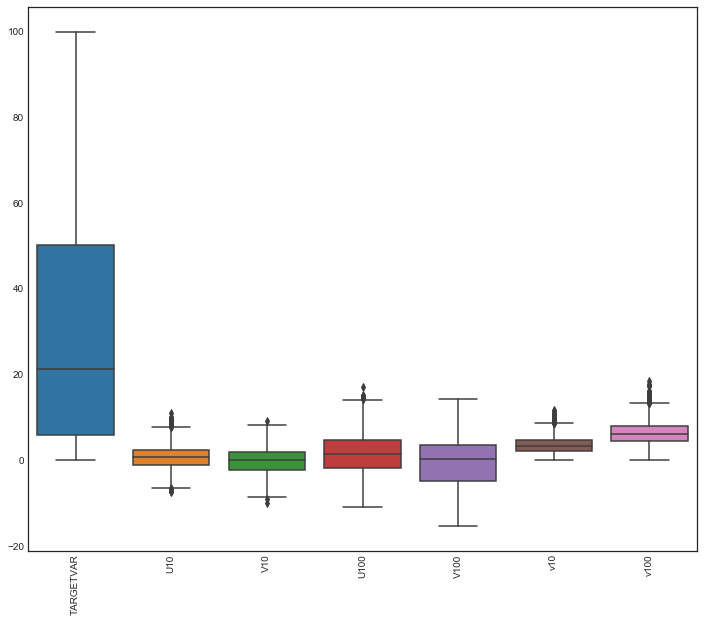

In [8]:
########## boxplots
# mostramos una gráfica con los boxplots de cada variable del dataframe. Este es un tipo de gráfica donde puede
# apreciarse fácilmente la dispersión de los datos o los valores outliers.
plt.figure(figsize=(12, 10))
sns.set_style("white")
bx_plot = sns.boxplot(data=df_energy)
plt.xticks(rotation=90)
plt.show()

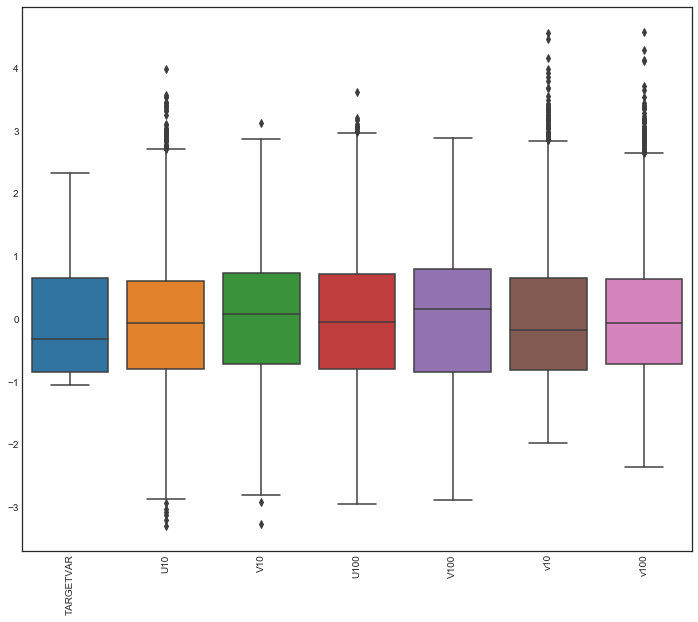

In [9]:
########## boxplots
# normalizamos los datos del dataframe para tener rangos lo más uniformes posibles a la hora de representar diagramas
# como los boxplots. Al volver a normalizar la variable targetvar ya no tiene valores tan dispares al resto y se pueden
# observar mejor los boxplots del resto de variables.
df_normalizado = (df_energy - df_energy.mean()) / df_energy.std() 

plt.figure(figsize=(12, 10))
sns.set_style("white")
bx_plot = sns.boxplot(data=df_normalizado)
plt.xticks(rotation=90)
plt.show()

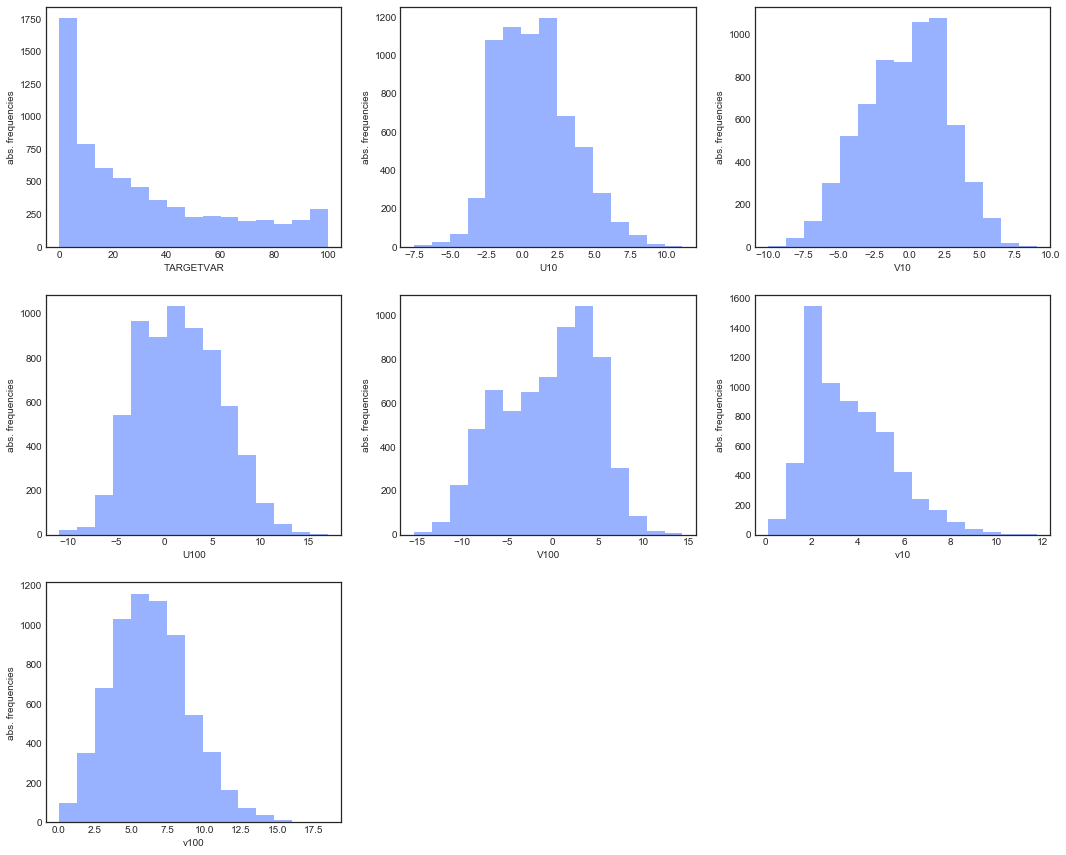

In [10]:
# mostramos el histograma para cada una de las variables del dataframe. Es junto al boxplot uno de los tipos de
# gráficos más utilizados.
vars_energy   = df_energy.columns[1 : ]
target_energy = df_energy.columns[0]

sns.set_color_codes("bright")
sns.set_style("white")

num_columns = 3
num_rows = int(np.ceil(len(df_energy.columns)/num_columns))

plt.figure(figsize=(18, 5*num_rows))

for i, var in enumerate (df_energy.columns):
    plt.subplot(num_rows, num_columns, i+1)
    sns.distplot( df_energy[var].iloc[:], bins=15, kde=False, color='b')
    plt.ylabel("abs. frequencies")
    plt.xlabel(var)
    
plt.show()

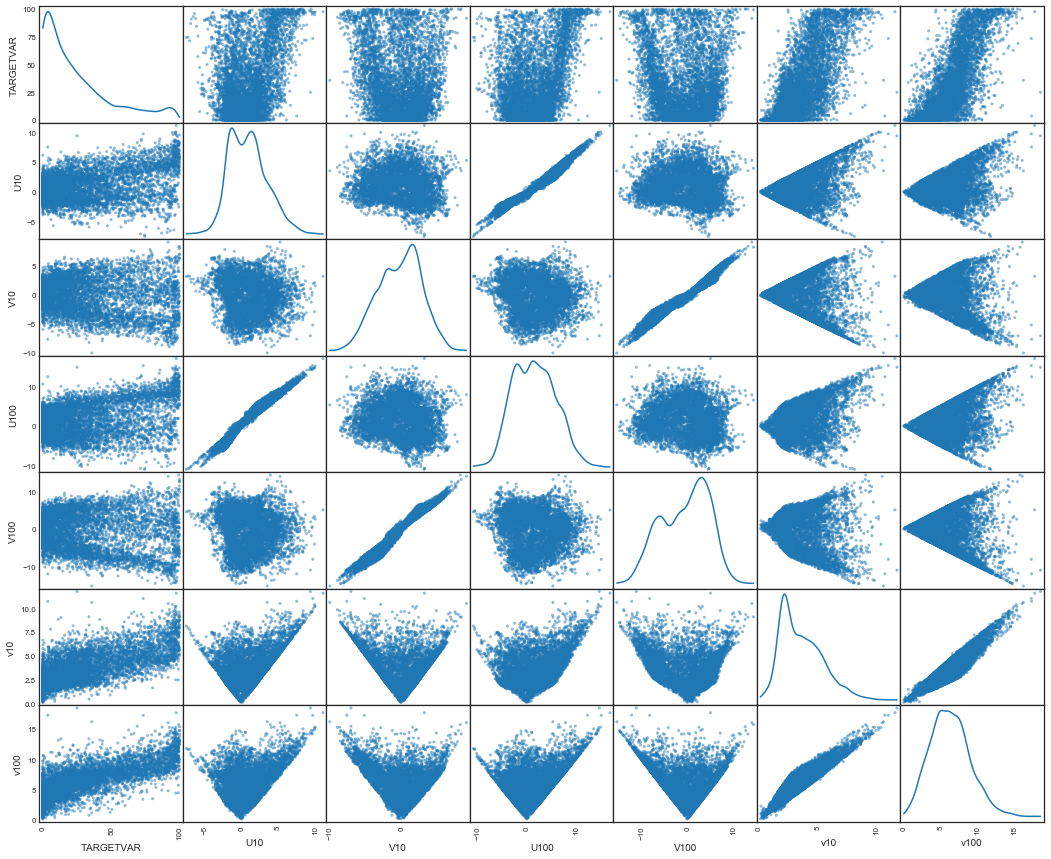

In [11]:
########## scatterplots-histograms
# Ahora mostramos diagramas de dispersión. En el primer caso con funciones de distribución en la diagonal.
# obtener los diagramas de dispersión sobre el fichero cargado
pair_plot = pd.plotting.scatter_matrix(df_energy[['TARGETVAR', 'U10', 'V10', 'U100', 'V100', 'v10', 'v100']], 
                                     alpha=0.5, figsize=(18, 5*num_rows), diagonal='kde')

plt.show()

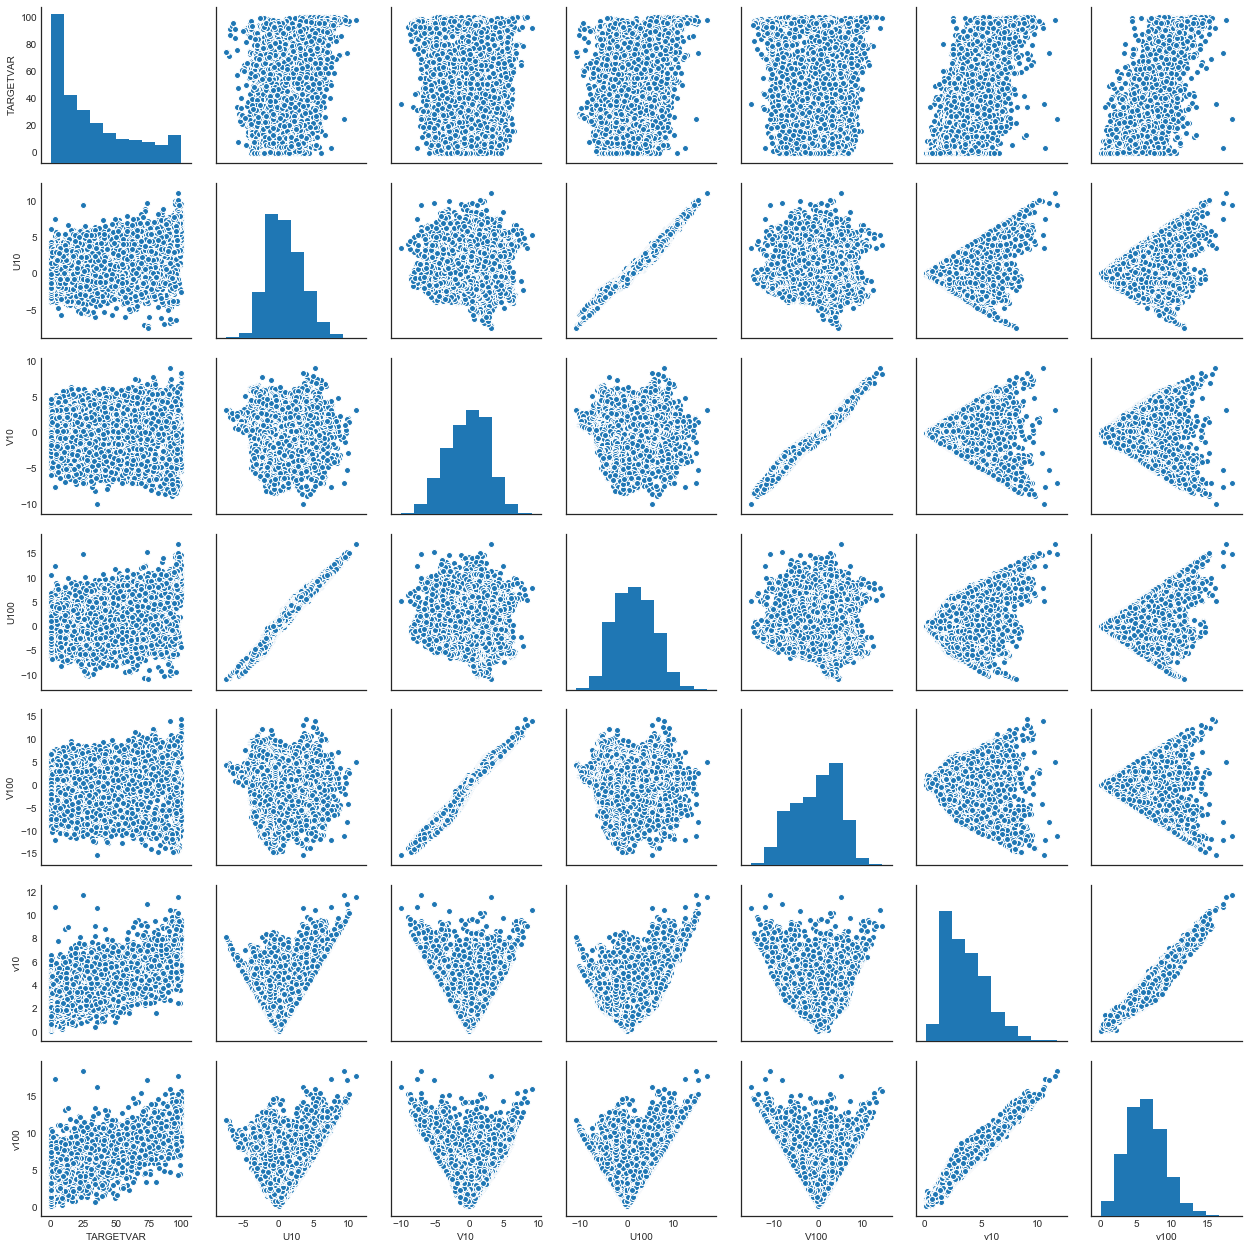

In [12]:
# Ahora pintamos otro gráfico de matriz de dispersión, esta vez con el uso de la librería seaborn y con los
# histogramas en la diagonal.
pair_plot = sns.pairplot(df_energy)
plt.show()

### First conclusions on the data

### Comentarios generales sobre los datos. ###
Los datos no tienen registros vacíos o nulos como se ha podido comprobar.
En el describe se observa que la variable TARGETVAR toma valores bastante diferentes al resto de variables, y que toma
valores en un rango bastante más grande, que puede verse también en sus valores más altos de la desviación o la varianza.
Sus datos están distribuidos a lo largo de un mayor rango de valores. El resto de valores se mueven en rangos de valores más similares, y viendo sus valores como la desviación más pequeña se puede decir que son más uniformes.

Cuando la media prácticamente coincide con la mitad del valor mínimo y el máximo, si además el percentil 50% también es prácticamente similar a la media, indica que la dispersión de los datos es pequeña y la mitad de los datos están en la parte izquierda del conjunto y la otra mitad en la parte derecha.
Bajo esta premisa, se puede observar que la variable TARGETVAR no está uniformemente distribuida en el rango de valores que toma, hay más valores en la parte baja del rango que hace que su media y percentil 50% sean más bajos de lo que deberían si lo estuviera.
El resto de variables como ya dijimos presentan menos dispersión y aparentemente son más uniformes, aunque como toman
rangos de valores más pequeños también influye para verlo de esa manera. Si vemos los valores de la media y percentil 50% obtenidos se puede apreciar que las variables "V10" y "V100" son las que tienen la media más cercana a la esperada y el percentil 50% también es muy similar, por lo que son las que presentan mayor uniformidad en la distribución de sus datos.
El resto de variables tienen valores de la media relativamente alejados de la esperada viendo el máximo y mínimo, lo
suficiente sabiendo que los rangos de valores son pequeños, aunque los percentiles 50% son muy cercanos a estas medias, por lo que el conjunto de datos se reparte bien según la media aunque dentro del rango que toma la variable habrá mayor número de datos más cercana a uno de los límites del rango y por tanto tiran de la media hacia su lado.


### Comentarios sobre los histogramas. ###
En los histogramas se puede apreciar la distribución de un conjunto de datos. Pueden apreciarse picos, simetría y asimetría del conjunto, o incluso datos atípicos u outliers.

Viendo los histogramas de cada una de las variables se puede apreciar como la variable "TARGETVAR" es la más distribuida a lo largo del rango de valores que toma, como se había visto en el primer análisis de las medidas tomadas. Además el mayor pico en el histograma para esta variable no está alrededor de la media, si no en valores más bajos, lo que explica que la media se vea afectada en este grupo de datos y baje su valor respecto al valor medio entre el valor máximo y el mínimo del rango de valores que toma la variable.

El resto de variables con los histogramas se puede apreciar una distribución menor de los datos dentro del rango de cada una, y de una forma más uniforme, donde los mayores picos coinciden con valores muy cercanos a la media obtenida de cada variable.
Además viendo la forma de los histogramas, se pueden apreciar similitudes en la distribución entre pares de variables: "U100" y "U10", "V100" y "V10", y "v100" y "v10". Estos tres pares de variables tienen los histogramas con una forma muy similar.
Por ejemplo los histogramas de las variables "v100" y "v10" son ambos asimétricos hacia la derecha, ya que concentran mayor parte de los datos en la parte izquierda.

En principio con los histogramas no se aprecian datos atípicos u outliers claros, esto podrá verse mejor con los boxplots.


### Comentarios sobre los boxplots. ###
Primero se han mostrado los boxplots de las variables sin normalizar, ya que en el enunciado se dice que la variable 
"TARGETVAR" está normalizada y toma valores de 0 a 100. Pero como se puede apreciar al tener esta variable un rango de
valores bastante diferente al resto dificulta algo la visualización de los boxplots de todas las variables en conjunto, asi que también se han mostrado posteriormente los boxplots volviendo a normalizar y de esa forma se ven mejor los boxplots del resto de variables.

El boxplot de la variable "TARGETVAR" muestra como hay mayor parte de los datos en la parte inferior del rango igual
que se veia en el histograma.
La mediana (la línea horizontal que está dentro de la caja) está en la parte baja de la caja, lo que indica que los datos comprendidos entre el percentil 25% y el percentil 50% están menos dispersos que los comprendidos entre el 50% y 75%.
El bigote superior es muy largo comparado con el inferior, debido a que los datos del rango superior están mucho más
dispersos.
No se aprecian valores outliers.

Observando los boxplots del resto de variables se puede apreciar mayor uniformidad ya que todas comparten un rango de
valores similar, además se aprecia mayor simetría en los boxplots con la longitud de los bigotes similar y cajas donde
la mediana esta más centrada lo que indica una distribución más uniforme de los datos.
En las variables "v10" y "v100" se observa una menor simetría, ya que los datos están algo más escorados hacia el rango inferior.
Lo que si se observa en casi todas estas variables son algunos datos outliers, que son datos que toman valores más
atípicos comparados con el resto, alejándose de los datos más comunes y estirando los valores máximos o mínimos del
conjunto de datos.


### Comentarios sobre las gráficas de dispersión. ###
Con las matrices de dispersión también podemos ver la distribución de los datos además viendo la relación entre cada
par de variables. En la diagonal de la matriz se pueden poner distintos tipos de gráficas, en este caso hemos dibujado dos matrices de dispersión una con la función de distribución en la diagonal y otra con los histogramas de cada variable. Por ejemplo viendo las funciones de distribución se aprecia como es muy similar para los tres pares de variables que comentamos anteriormente.

Pero donde mejor se ve la relación entre variables es la parte de la matriz de dispersión que las relaciona, donde las
variables que tienen alta relación forman prácticamente una recta. Si la recta es creciente significa que cuando aumenta el valor de la variable x también aumenta el valor de la variable y. Al contrario si la recta es decreciente.
En este caso se aprecia la alta relación entre los tres pares de variables: "U100"-"U10", "V100"-"V10", y "v100"-"v10", y ademas que es una recta creciente por lo que la relación será cercana a 1 entre cada par de variables. 

In [13]:
########## correlations
# Obtenemos la matriz de correlación entre cada par de variables del dataframe.
df_energy.corr().round(decimals=3)

,TARGETVAR,U10,V10,U100,V100,v10,v100
TARGETVAR,1.000,0.377,-0.166,0.365,-0.177,0.706,0.745
U10,0.377,1.000,-0.098,0.981,-0.058,0.441,0.392
V10,-0.166,-0.098,1.000,-0.133,0.981,-0.162,-0.257
U100,0.365,0.981,-0.133,1.000,-0.095,0.394,0.364
V100,-0.177,-0.058,0.981,-0.095,1.000,-0.172,-0.279
v10,0.706,0.441,-0.162,0.394,-0.172,1.000,0.915
v100,0.745,0.392,-0.257,0.364,-0.279,0.915,1.000


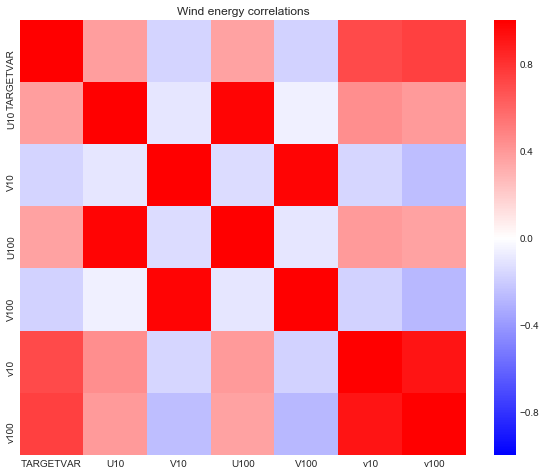

In [14]:
# correlation heatmap
# Pintamos las correlaciones en un mapa de calor, donde para cada par de variables se representa su grado de 
# correlación con un color.
plt.figure( figsize=(10, 8))
plt.title('Wind energy correlations')
_ = sns.heatmap(df_energy.corr().values, vmin=-1., vmax=1., cmap='bwr', 
                xticklabels=list(df_energy.columns), yticklabels=list(df_energy.columns))

In [15]:
# Se puede obtener para cada variable la lista de correlación con el resto, y ordenar para ver rápidamente con
# que variables guarda más correlacion, en caso de que tenga con alguna. Mostramos la correlación para 3 de las
# variables donde se puede apreciar la alta correlación que guardan con otra variable.
print((df_energy.corr()['v100'].abs().sort_values(ascending=False).T))
print((df_energy.corr()['V100'].abs().sort_values(ascending=False).T))
print((df_energy.corr()['U100'].abs().sort_values(ascending=False).T))

v100         1.000000
v10          0.915233
TARGETVAR    0.745069
U10          0.392386
U100         0.364379
V100         0.279364
V10          0.256600
Name: v100, dtype: float64
V100         1.000000
V10          0.980580
v100         0.279364
TARGETVAR    0.176532
v10          0.172034
U100         0.095369
U10          0.057997
Name: V100, dtype: float64
U100         1.000000
U10          0.980816
v10          0.393860
TARGETVAR    0.364739
v100         0.364379
V10          0.133223
V100         0.095369
Name: U100, dtype: float64


           TARGETVAR     U10     V10    U100    V100     v10    v100
TARGETVAR    874.108  28.463 -14.640  45.817 -26.756  37.062  58.464
U10           28.463   6.524  -0.751  10.644  -0.759   2.000   2.660
V10          -14.640  -0.751   8.914  -1.690  15.008  -0.860  -2.033
U100          45.817  10.644  -1.690  18.052  -2.077   2.971   4.109
V100         -26.756  -0.759  15.008  -2.077  26.280  -1.566  -3.801
v10           37.062   2.000  -0.860   2.971  -1.566   3.152   4.313
v100          58.464   2.660  -2.033   4.109  -3.801   4.313   7.044


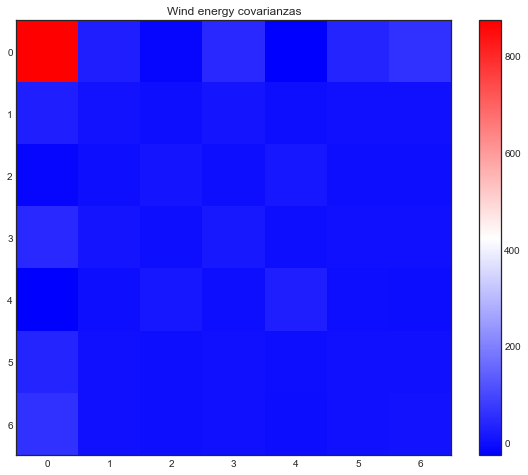

In [16]:
# Ahora mostramos la matriz de covarianzas sobre el dataframe. La covarianza es otra forma de analizar la
# distribución de los datos.
print(df_energy.cov().round(decimals=3))

# mostramos la gráfica de covarianza de los datos
plt.figure(figsize=(10, 8))
plt.title('Wind energy covarianzas')
_ = plt.colorbar(plt.imshow(np.cov(df_energy.T), cmap="bwr"))

           TARGETVAR    U10    V10   U100   V100    v10   v100
TARGETVAR      1.000  0.377 -0.166  0.365 -0.177  0.706  0.745
U10            0.377  1.000 -0.098  0.981 -0.058  0.441  0.392
V10           -0.166 -0.098  1.000 -0.133  0.981 -0.162 -0.257
U100           0.365  0.981 -0.133  1.000 -0.095  0.394  0.364
V100          -0.177 -0.058  0.981 -0.095  1.000 -0.172 -0.279
v10            0.706  0.441 -0.162  0.394 -0.172  1.000  0.915
v100           0.745  0.392 -0.257  0.364 -0.279  0.915  1.000


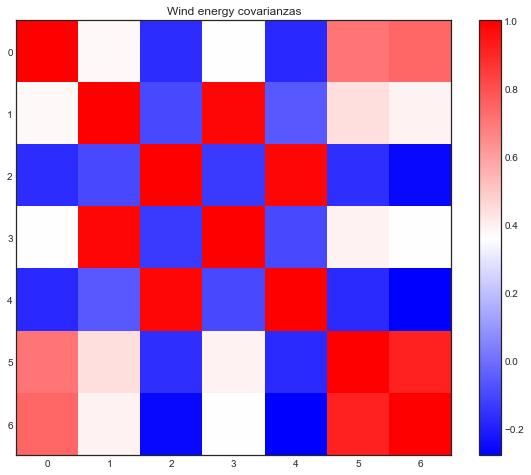

In [17]:
# Ahora mostramos la matriz de covarianzas sobre el dataframe normalizado, para poder visualizar bien todas las
# variables ya que en el anterior al estar targetvar en unos valores bastante diferentes al resto no permitía una
# correcta interpretación.
print(df_normalizado.cov().round(decimals=3))

# mostramos la gráfica de covarianza de los datos
plt.figure(figsize=(10, 8))
plt.title('Wind energy covarianzas')
_ = plt.colorbar(plt.imshow(np.cov(df_normalizado.T), cmap="bwr"))

### First conclusions on the predictive potential of linear models

### Interpretar y comentar los resultados anteriores obtenidos sobre el cálculo de correlaciones y covarianzas. ###
### Correlaciones ###
El gráfico de correlación representa la matriz de correlación entre cada par de variables del conjunto de datos. Cada cuadrado en el eje "x" y eje "y" representa a una de las variables del conjunto de datos.
La diagonal de la gráfica será correlación total, valor 1 ya que relaciona a cada variable consigo misma. Al lado del gráfico está la leyenda de colores para ver según el color de cada cuadrado el grado de relación entre esas dos variables.

La correlación alta entre dos variables debe ser cercana a 1 o cercana a -1. Según se aprecia en la matriz de los valores mostrada o en la gráfica, vemos como hay una alta relación para los tres pares de variables vistos antes con otros gráficos:
U10-U100 --> 0.98
V10-V100 --> 0.98
v10-v100 --> 0.9152
Estas relaciones altas entre las variables se muestran en la matriz de correlación con el color fuerte correspondiente al 1 o valores cercanos. 
Al ser valores positivos cercanos a 1 indica que cuando crece el valor de una de las variables crece también el valor de la otra variable relacionada.


### Covarianzas ###
El gráfico de covarianzas representa la matriz de covarianza entre cada par de variables del conjunto de datos.
La diagonal de la gráfica representa la varianza de cada propiedad. 

En la primera gráfica de covarianzas se puede ver como el mayor valor y alejado del resto en la diagonal corresponde a la variable "TARGETVAR", algo que ya se vio cuando se calcularon los valores de la varianza para cada variable.

Como en ese gráfica de covarianzas no se aprecia nada sobre el resto, se muestra otra sobre el dataframe normalizado, y así se pueden apreciar los resultados para el resto de variables.
La covarianza positiva entre dos variables indica una relación directa, y que cuando una variable crece la otra variable también lo hace. Y una covarianza negativa indica una relación inversa, que cuando una variable crece la otra variable decrece.

Entonces se puede ver de nuevo como los pares de variables que guardaban mayor relación anteriormente con las correlaciones vuelven a hacerlo ahora con las covarianzas.
Estos pares de variables relacionados tienen valor positivo que indica relación directa.

## First linear model

### Selecting the $\alpha$ hyperparameter

Since the data correspond essentially to a 9-month period, use GridSearchCV on an appropriate $\alpha$ grid to select an optimal value with 9 folds os consecutive data (which should correspond to approximately one month). 

b: 30.994200


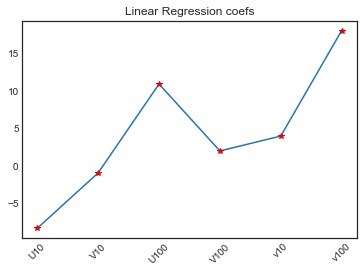

In [18]:
########## normalize the data and set up a GridSearchCV
########## compute and save the search results
########## give a first check of the adequacy of the selected alpha
lr_m = Ridge()

std_sc = StandardScaler()
# sacamos las variables independientes y dependientes
x = std_sc.fit_transform(df_energy[vars_energy].values)
y = df_energy[target_energy].values

#ajuste sobre la muestra completa, sin split train-test.
# entrenamos el modelo con las variables independientes y dependientes
lr_m.fit(x, y)

print("b: %f" % lr_m.intercept_)

# coeficientes regresión lineal de cada variable independiente
nticks = len(lr_m.coef_)
plt.xticks(range(len(vars_energy)), vars_energy, rotation=45)
plt.title('Linear Regression coefs')
_ = plt.plot(lr_m.coef_, '-', lr_m.coef_, 'r*')

In [20]:
# coeficientes asignados a cada atributo. Se pueden ver los que más contribuyen a variar la variable dependiente
for (feature, coef) in zip(df_energy[vars_energy], lr_m.coef_):
    print('{:>7}: {: 9.5f}'.format(feature, coef))

    U10:  -8.32699
    V10:  -0.94483
   U100:  10.88952
   V100:   1.97530
    v10:   3.95721
   v100:  18.01088


MAE: 15.156		R^2: 0.570


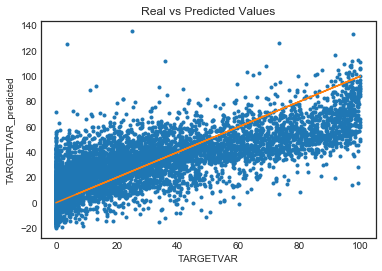

In [21]:
# obtenemos valores de la media del error absoluto y el score del modelo
y_pred = lr_m.predict(x)

print("MAE: %.3f\t\tR^2: %.3f" % (mean_absolute_error(y, y_pred), lr_m.score(x, y)))

plt.title('Real vs Predicted Values')
plt.xlabel('TARGETVAR')
plt.ylabel('TARGETVAR_predicted')
_ = plt.plot(y, y_pred, '.', y, y, '-')

In [22]:
n_folds = 9
kf = KFold(n_folds, shuffle=True)

scores = cross_val_score(lr_m, x, y, scoring="neg_mean_absolute_error", cv=kf)

print("mae_mean: %.3f\t\tmae_std: %.3f" % (-scores.mean(), scores.std()))

mae_mean: 15.177		mae_std: 0.426


In [23]:
# select alpha in ridge regression by CV
# First iteration to find alpha
n_folds = 9

# no shuffle 
kf = KFold(n_folds, shuffle=True)

l_alpha = [2.**k for k in range(-6, 10)]
param_grid = {'alpha': l_alpha}

lr_m = Ridge()
ridge_alpha_search = GridSearchCV(lr_m, param_grid=param_grid, cv=kf, 
                                  scoring='neg_mean_absolute_error',
                                  n_jobs=2, verbose=1)

ridge_alpha_search.fit(x, y)

Fitting 9 folds for each of 16 candidates, totalling 144 fits


[Parallel(n_jobs=2)]: Done 144 out of 144 | elapsed:    0.3s finished


GridSearchCV(cv=KFold(n_splits=9, random_state=None, shuffle=True),
       error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid=True, n_jobs=2,
       param_grid={'alpha': [0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5, 1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0, 256.0, 512.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=1)

alfa = 64.00
best_cv_mae = 15.152


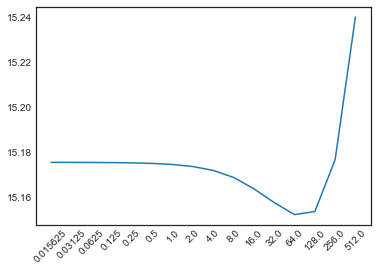

In [25]:
print('alfa = %.2f' % (ridge_alpha_search.best_params_['alpha']))
print('best_cv_mae = %.3f' % (-ridge_alpha_search.best_score_))

plt.xticks(range(len(l_alpha)), l_alpha, rotation=45)
_ = plt.plot( -ridge_alpha_search.cv_results_['mean_test_score'])

In [26]:
#Segunda iteración: recentramos alpha y refinamos la búsqueda
kf = KFold(n_folds, shuffle=True)

l_alpha = [32. * 2.**(k/2.) for k in range(-5, 4)]
param_grid = {'alpha': l_alpha}

lr_m = Ridge()
ridge_alpha_search = GridSearchCV(lr_m, param_grid=param_grid, cv=kf, 
                                  scoring='neg_mean_absolute_error',
                                  n_jobs=2, verbose=1)

ridge_alpha_search.fit(x, y)

Fitting 9 folds for each of 9 candidates, totalling 81 fits


[Parallel(n_jobs=2)]: Done  81 out of  81 | elapsed:    0.2s finished


GridSearchCV(cv=KFold(n_splits=9, random_state=None, shuffle=True),
       error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid=True, n_jobs=2,
       param_grid={'alpha': [5.656854249492381, 8.0, 11.313708498984761, 16.0, 22.627416997969522, 32.0, 45.254833995939045, 64.0, 90.50966799187809]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=1)

alfa = 90.51
best_cv_mae = 15.150


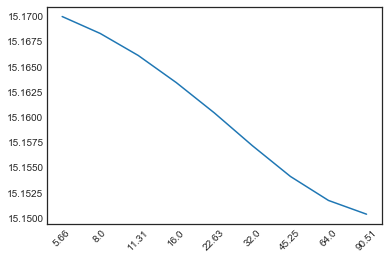

In [28]:
print('alfa = %.2f' % (ridge_alpha_search.best_params_['alpha']))
print('best_cv_mae = %.3f' % (-ridge_alpha_search.best_score_))

plt.xticks(range(len(l_alpha)), np.round(l_alpha, 2), rotation=45)
_ = plt.plot( -ridge_alpha_search.cv_results_['mean_test_score'])

### Estimating model performance

Do it using an appropriate cv tool.

In [29]:
########## CV-based performance estimate
best_alpha = ridge_alpha_search.best_params_['alpha']
lr_m = Ridge(alpha=best_alpha)

scores = cross_val_score(lr_m, x, y, scoring="neg_mean_absolute_error", cv=kf)

print("mae_mean: %.3f\t\tmae_std: %.3f" % (-scores.mean(), scores.std()))

mae_mean: 15.150		mae_std: 0.338


### Analyzing model predictions and  residuals

Compare visually the model predictions with their targets as well as the residuals.

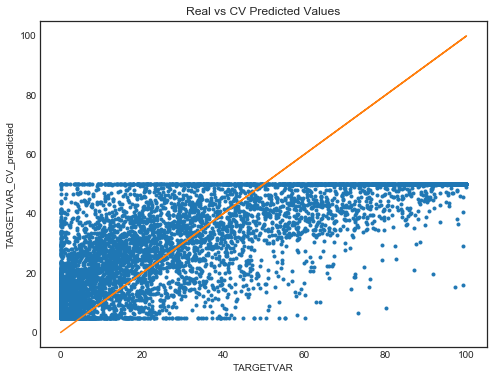

In [30]:
########## targets vs predictions
y_pred = np.clip( cross_val_predict(lr_m, x, y, cv=kf), 5., 50.)

plt.figure( figsize=(8,6))

plt.title('Real vs CV Predicted Values')
plt.xlabel('TARGETVAR')
plt.ylabel('TARGETVAR_CV_predicted')
_ = plt.plot(y, y_pred, '.', y, y, '-')

mae: 16.357


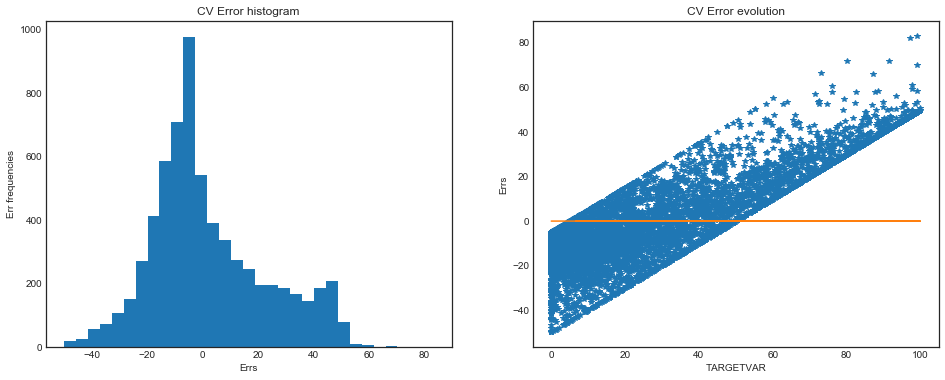

In [31]:
########## residual structure and behavior
err = y - y_pred

print("mae: %.3f" % (abs(err).mean()) )

plt.figure( figsize=(16,6))

plt.subplot(1,2,1)
plt.title("CV Error histogram")
plt.xlabel("Errs")
plt.ylabel("Err frequencies")
_ = plt.hist(err, bins=31)

plt.subplot(1,2,2)
plt.title("CV Error evolution")
plt.xlabel("TARGETVAR")
plt.ylabel("Errs")
_ = plt.plot(y, err, '*', y, 0.*y, '-')

plt.show()

MAE: 15.135		R^2: 0.569


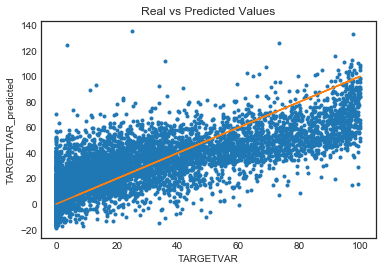

In [32]:
best_alpha = ridge_alpha_search.best_params_['alpha']
lr_m = Ridge(alpha=best_alpha)
lr_m.fit(x,y)
y_pred = lr_m.predict(x)

print("MAE: %.3f\t\tR^2: %.3f" % (mean_absolute_error(y, y_pred), lr_m.score(x, y)))

plt.title('Real vs Predicted Values')
plt.xlabel('TARGETVAR')
plt.ylabel('TARGETVAR_predicted')
_ = plt.plot(y, y_pred, '.', y, y, '-')

### Conclusions on the linear model

### Conclusiones del modelo lineal. ###
Puede decirse que un modelo de regresión lineal simple (Linear Regression) funciona modelando la relación existente entre un input (variable explicativa x) y un output (variable objetivo y).
El objetivo de este modelo es descubrir los coeficientes que describen la relación existente entre las variables de entrada (variable explicativa) y las de salida (variable objetivo), de manera que puedan ser utilizados para predecir nuevos datos que no formen parte del subconjunto de entrenamiento. Es decir, el modelo trata de encontrar la línea que mejor se ajusta al subconjunto de entrenamiento.
El modelo se alimenta con los datos de entrenamiento y se desean generar los siguientes tres datos:
- Coefficients: coeficientes del ajuste.
- Intercept: intersección con el eje y.
- Score (R2): coeficiente de determinación.
El R2 o coeficiente de determinación es una versión estandarizada del error cuadrático medio (MSE) que proporciona una mejora en la interpretabilidad del rendimiento del modelo. 

El método LinearRegression empleado para definir el modelo lineal ha de recibir los datos de entrenamiento del dataset, tanto los input como los output. Una vez entrenado, pueden obtenerse directamente los coeficientes del mismo, la intersección con el eje y, además del coeficiente de determinación.

Se han estandarizado los valores utilizando el transformado StandardScaler. El transformador StandardScaler evita tener que ir ajustando y transformando en el subconjunto de entrenamiento y en el de evaluación por separado, se trata de otra forma de escalar atributos en la que los valores estandarizados tienen una media igual a cero.
Una ventaja de la estandarización es que se ve menos afectada por los valores erróneos.

Se ha usado la validación cruzada de K iteraciones (K-Fold Cross-Validation) en la que:
- Se divide el subconjunto de entrenamiento en K pliegues.
- En cada iteración:
    Se entrena el modelo con todos de las particiones, menos una.
    Con el modelo entrenado, se hacen predicciones para la partición que se ha excluido del entrenamiento.
    Dichas predicciones se evalúan y se calcula el rendimiento (proporción de mediciones correctas), usando el modelo entrenado en el resto de combinaciones.
- Se calcula el rendimiento medio en cada caso.

También se ha usado GridSearchCV, que considera exhaustivamente todas las combinaciones de parámetros.
Cuando se ajusta un conjunto de datos, se evalúan todas las posibles combinaciones de valores de parámetros y solo se conserva la mejor combinación de ellas.


De los valores obtenidos en el caso de Regresión Lineal se concluye que el modelo no ajusta del todo bien los datos, ya que el valor score queda ciertamente lejano al valor 1 que indicaría el ajuste perfecto. Puede verse además en la gráfica de valores reales con los predecidos que no ajusta bien a la recta y hay bastante dispersión. 
Esto podría indicar que se debe de buscar un modelo más complejo para ajustar mejor. También mientras menor sea el error medio será mejor la precisión e interpretabilidad del modelo.

Además los valores de α elevados implican que el modelo está ciertamente penalizado.

## Working with more variables

A simple way to get a non linear model using Ridge Regression is to add new features to the model derived, for instance, from powers of some of the most relevant features.

Do so here adding as new features the squares and cubes of the v10 and v100 variables and redo the steps above that you might think necessary.

b: 11.175866


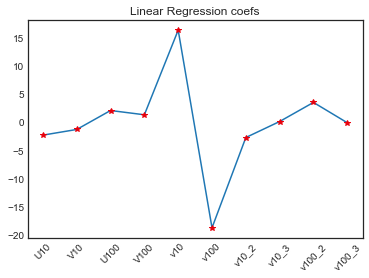

In [35]:
# se añaden la dataframe las nuevas variables sugeridas como los cuadrados y cubos de las variables v10 y v100
df_energy['v10_2'] = df_energy['v10'] **2
df_energy['v10_3'] = df_energy['v10'] **3
df_energy['v100_2'] = df_energy['v100'] **2
df_energy['v100_3'] = df_energy['v100'] **3

lr_m = Ridge()

vars_energy   = df_energy.columns[1 : ]
target_energy = df_energy.columns[0]

x = df_energy[vars_energy].values
y = df_energy[target_energy].values

#ajuste sobre la muestra completa, sin split train-test
lr_m.fit(x, y)

print("b: %f" % lr_m.intercept_)

nticks = len(lr_m.coef_)
plt.xticks(range(len(vars_energy)), vars_energy, rotation=45)
plt.title('Linear Regression coefs')
_ = plt.plot(lr_m.coef_, '-', lr_m.coef_, 'r*')

In [36]:
# coeficientes asignados a cada atributo. Se pueden ver los que más contribuyen a variar la variable dependiente
for (feature, coef) in zip(df_energy[vars_energy], lr_m.coef_):
    print('{:>7}: {: 9.5f}'.format(feature, coef))

    U10:  -2.33295
    V10:  -1.32342
   U100:   2.05911
   V100:   1.29695
    v10:  16.39642
   v100: -18.86614
  v10_2:  -2.76129
  v10_3:   0.09642
 v100_2:   3.50151
 v100_3:  -0.12478


MAE: 13.994		R^2: 0.611


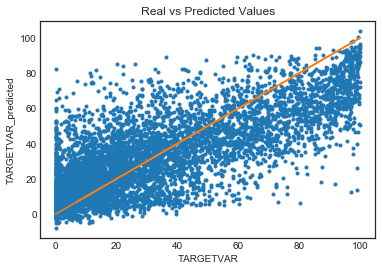

In [37]:
y_pred = lr_m.predict(x)

print("MAE: %.3f\t\tR^2: %.3f" % (mean_absolute_error(y, y_pred), lr_m.score(x, y)))

plt.title('Real vs Predicted Values')
plt.xlabel('TARGETVAR')
plt.ylabel('TARGETVAR_predicted')
_ = plt.plot(y, y_pred, '.', y, y, '-')

In [38]:
n_folds = 9
kf = KFold(n_folds, shuffle=True)

scores = cross_val_score(lr_m, x, y, scoring="neg_mean_absolute_error", cv=kf)

print("mae_mean: %.3f\t\tmae_std: %.3f" % (-scores.mean(), scores.std()))

mae_mean: 14.021		mae_std: 0.458


In [39]:
# select alpha in ridge regression by CV
# First iteration to find alpha
n_folds = 9

# no shuffle 
kf = KFold(n_folds, shuffle=True)

l_alpha = [2.**k for k in range(-6, 10)]
param_grid = {'alpha': l_alpha}

lr_m = Ridge()
ridge_alpha_search = GridSearchCV(lr_m, param_grid=param_grid, cv=kf, 
                                  scoring='neg_mean_absolute_error',
                                  n_jobs=1, verbose=1)

ridge_alpha_search.fit(x, y)

Fitting 9 folds for each of 16 candidates, totalling 144 fits


[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed:    0.4s finished


GridSearchCV(cv=KFold(n_splits=9, random_state=None, shuffle=True),
       error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': [0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5, 1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0, 256.0, 512.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=1)

alfa = 16.00
best_cv_mae = 14.015


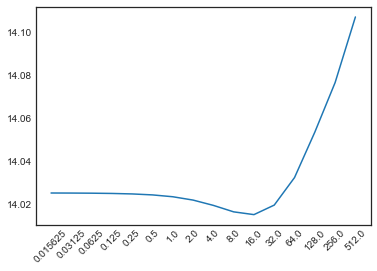

In [40]:
print('alfa = %.2f' % (ridge_alpha_search.best_params_['alpha']))
print('best_cv_mae = %.3f' % (-ridge_alpha_search.best_score_))

plt.xticks(range(len(l_alpha)), l_alpha, rotation=45)
_ = plt.plot( -ridge_alpha_search.cv_results_['mean_test_score'])

In [41]:
#Segunda iteración: recentramos alpha y refinamos la búsqueda
kf = KFold(n_folds, shuffle=True)

l_alpha = [32. * 2.**(k/2.) for k in range(-5, 4)]
param_grid = {'alpha': l_alpha}

lr_m = Ridge()
ridge_alpha_search = GridSearchCV(lr_m, param_grid=param_grid, cv=kf, 
                                  scoring='neg_mean_absolute_error',
                                  n_jobs=1, verbose=1)

ridge_alpha_search.fit(x, y)

Fitting 9 folds for each of 9 candidates, totalling 81 fits


[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed:    0.2s finished


GridSearchCV(cv=KFold(n_splits=9, random_state=None, shuffle=True),
       error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': [5.656854249492381, 8.0, 11.313708498984761, 16.0, 22.627416997969522, 32.0, 45.254833995939045, 64.0, 90.50966799187809]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=1)

alfa = 11.31
best_cv_mae = 14.012


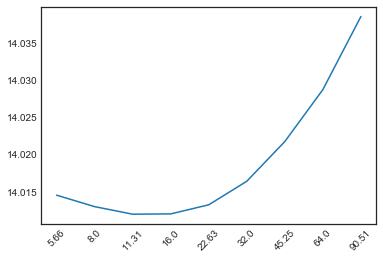

In [42]:
print('alfa = %.2f' % (ridge_alpha_search.best_params_['alpha']))
print('best_cv_mae = %.3f' % (-ridge_alpha_search.best_score_))

plt.xticks(range(len(l_alpha)), np.round(l_alpha, 2), rotation=45)
_ = plt.plot( -ridge_alpha_search.cv_results_['mean_test_score'])

In [43]:
########## CV-based performance estimate
best_alpha = ridge_alpha_search.best_params_['alpha']
lr_m = Ridge(alpha=best_alpha)

scores = cross_val_score(lr_m, x, y, scoring="neg_mean_absolute_error", cv=kf)

print("mae_mean: %.3f\t\tmae_std: %.3f" % (-scores.mean(), scores.std()))

mae_mean: 14.012		mae_std: 0.435


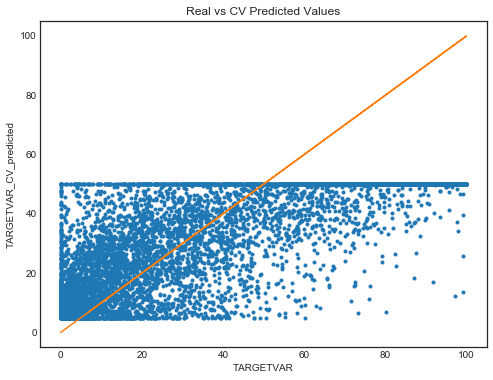

In [44]:
########## targets vs predictions
y_pred = np.clip( cross_val_predict(lr_m, x, y, cv=kf), 5., 50.)

plt.figure( figsize=(8,6))

plt.title('Real vs CV Predicted Values')
plt.xlabel('TARGETVAR')
plt.ylabel('TARGETVAR_CV_predicted')
_ = plt.plot(y, y_pred, '.', y, y, '-')

mae: 15.863


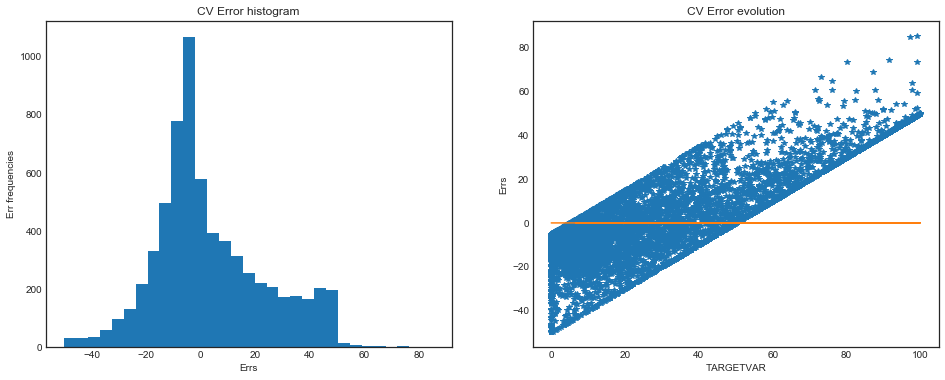

In [45]:
########## residual structure and behavior
err = y - y_pred

print("mae: %.3f" % (abs(err).mean()) )

plt.figure( figsize=(16,6))

plt.subplot(1,2,1)
plt.title("CV Error histogram")
plt.xlabel("Errs")
plt.ylabel("Err frequencies")
_ = plt.hist(err, bins=31)

plt.subplot(1,2,2)
plt.title("CV Error evolution")
plt.xlabel("TARGETVAR")
plt.ylabel("Errs")
_ = plt.plot(y, err, '*', y, 0.*y, '-')

plt.show()

### Conclusions on the second linear model

### Conclusiones del segundo modelo lineal. ###
Se han añadido los nuevos atributos en base a dos de las variables ya existentes, calculando los cuadrados y cubos de
los valores de dichas variables. 
Al calcular el modelo vemos como no ha cambiado excesivamente respecto al anterior, aunque ha disminuido algo el error
medio absoluto y ha aumentado algo el score, por lo tanto este segundo modelo ha mejorado algo la capacidad de predición.
Además el valor de α ha disminuido considerablemente lo que también es mejor señal que el anterior.